In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

In [2]:
appeals_df = pd.read_csv('../data/zoning_board_appeals_tracker.csv')
print(appeals_df.shape)
print(appeals_df.columns.to_list())
appeals_df.head()

(9043, 19)
['address', 'status', 'parent_apno', 'boa_apno', 'appeal_type', 'contact', 'submitted_date', 'received_date', 'hearing_date', 'ever_deferred', 'num_deferrals', 'final_decision_date', 'decision', 'closed_date', 'city', 'zip', 'ward', 'zoning_district', 'project_description']


,address,status,parent_apno,boa_apno,appeal_type,contact,submitted_date,received_date,hearing_date,ever_deferred,num_deferrals,final_decision_date,decision,closed_date,city,zip,ward,zoning_district,project_description
0,14 Victoria ST Dorchester 02125,Community Process,U491529793,BOA1534425,Zoning,Matt Jeske,2023-10-10,2023-10-10,NaN,NaN,NaN,NaN,NaN,NaN,Dorchester,2125,13,Dorchester Neighborhood,We would to add 2 vehicle driveway on left sid...
1,122 Seaver ST Dorchester 02121,Community Process,U491485629,BOA1534528,Zoning,Erika Guerrero,2023-10-10,2023-10-10,NaN,NaN,NaN,NaN,NaN,NaN,Dorchester,2121,12,Roxbury Neighborhood,Use or premises Food trailer in parking space ...
2,9 Mckay Pl East Boston 02128,Community Process,ERT1523974,BOA1534462,Zoning,derric small,2023-10-10,2023-10-10,NaN,NaN,NaN,NaN,NaN,NaN,East Boston,2128,1,East Boston Neighborhood,Demolish existing structures combine lots erec...
3,3927 Washington ST Roslindale 02131,Community Process,ALT1522878,BOA1534015,Zoning,Anthony Ross,2023-10-07,2023-10-10,NaN,NaN,NaN,NaN,NaN,NaN,Roslindale,2131,19,Jamaica Plain Neighborhood,Add 4th floor to existing 3 story unit buildin...
4,27 Hopkins Rd Jamaica Plain 02130,Community Process,ERT1432001,BOA1534017,Zoning,Anthony Ross,2023-10-07,2023-10-10,NaN,NaN,NaN,NaN,NaN,NaN,Jamaica Plain,2130,19,Jamaica Plain Neighborhood,Erect single family home with attached two car...


['Denied', 'Withdrawn', 'DeniedPrej', 'Approved', 'AppProv']


<BarContainer object of 5 artists>

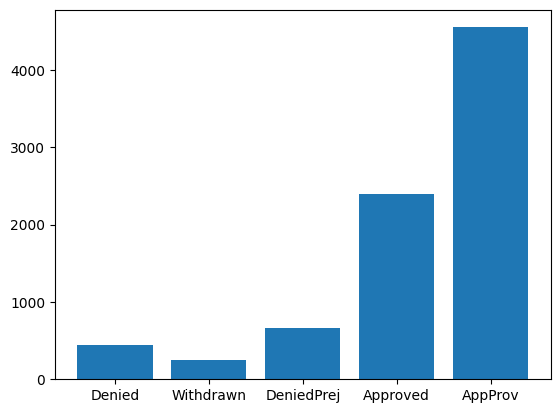

In [3]:
labels = [label for label in list(set(appeals_df['decision'])) if type(label) == str and label.strip() != '']
print(labels)
y_vals = [
    appeals_df[appeals_df['decision'] == label]['decision'].count() for label in labels
]

# Note: see that most appeals are approved, < 1000 are denied or denied with prejudice
plt.bar(labels, y_vals)

In [4]:
denied_df = appeals_df.query('decision == "Denied" | decision == "DeniedPrej"')

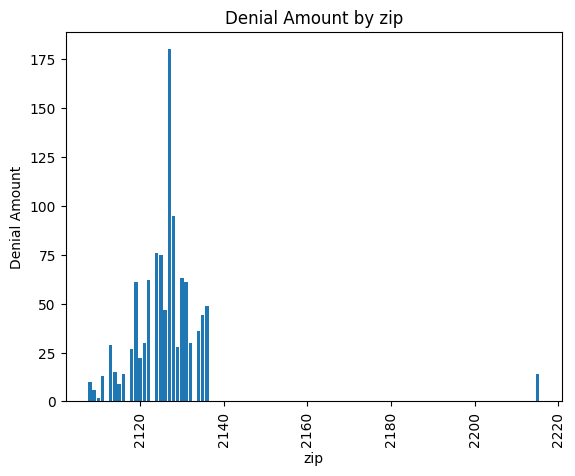

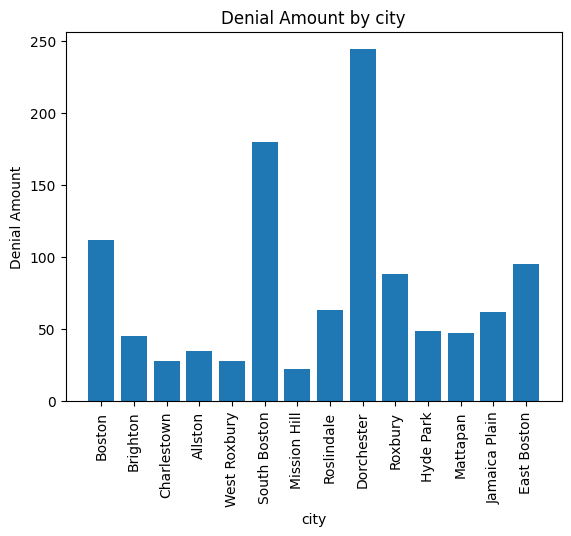

In [66]:
# Count zipcode, city, etc for denied permits

def count_labels(df, column_name):
    labels = [label for label in list(set(df[column_name]))]
    y_vals = [
        df[df[column_name] == label][column_name].count() for label in labels
    ]

    # Note: see that most appeals are approved, < 1000 are denied or denied with prejudice
    plt.title(f"Denial Amount by {column_name}")
    plt.ylabel("Denial Amount")
    plt.xlabel(column_name)
    plt.bar(labels, y_vals)
    plt.xticks(rotation = 90)
    plt.show()

count_labels(denied_df, "zip")
count_labels(denied_df, "city")

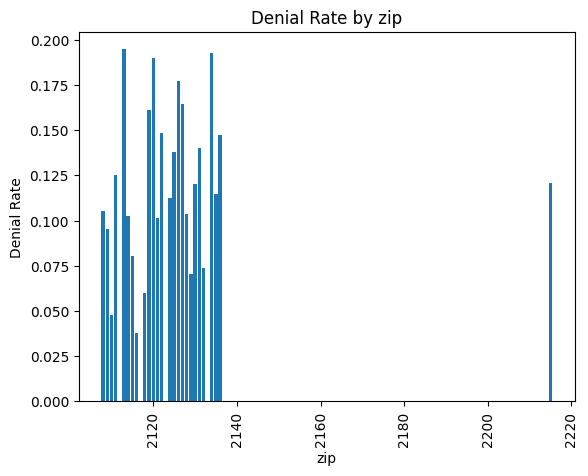

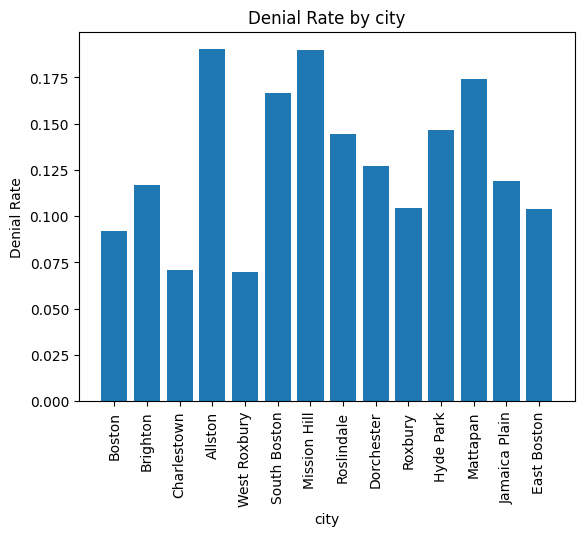

In [65]:
# Normalize by number of appeals in zip code

# Clean up city outliers
for city in list(set(denied_df['city'])):
    if len(denied_df[denied_df['city'] == city]) < 3:
        denied_df = denied_df[denied_df['city'] != city]
 
def count_labels_norm(df, column_name):
    labels = [label for label in list(set(df[column_name]))]
    y_vals = [
        ((df[df[column_name] == label][column_name].count()) / (appeals_df[appeals_df[column_name] == label].shape[0])) for label in labels
    ]

    # Note: see that most appeals are approved, < 1000 are denied or denied with prejudice
    plt.title(f"Denial Rate by {column_name}")
    plt.ylabel("Denial Rate")
    plt.xlabel(column_name)
    plt.bar(labels, y_vals)
    plt.xticks(rotation = 90)
    plt.show()

count_labels_norm(denied_df, "zip")
count_labels_norm(denied_df, "city")

In [7]:
census_df = pd.read_csv('../data/redistricting_data_tract20_nbhd_hhpopsize_ab-1.csv')
voterdata_df = pd.read_csv('../data/VM2Uniform--MA--2021-01-19.tab', sep='\t', encoding='iso-8859-1', usecols=['Residence_Addresses_Zip', 'CommercialData_EstimatedHHIncomeAmount'])
voterdata_df.head()

,Residence_Addresses_Zip,CommercialData_EstimatedHHIncomeAmount
0,2638.0,$76957
1,2638.0,$76957
2,2638.0,$76957
3,2532.0,$118213
4,2563.0,NaN


In [25]:
zip_income_data = zip(voterdata_df['Residence_Addresses_Zip'], voterdata_df['CommercialData_EstimatedHHIncomeAmount'])

zip_to_mean_income = dict.fromkeys(voterdata_df['Residence_Addresses_Zip'], None)

for zipcode, income in zip_income_data:
    try:
        if zip_to_mean_income[zipcode] is None:
            zip_to_mean_income[zipcode] = []
        if type(income) == str:
            income = int(income[1:])
            zip_to_mean_income[zipcode].append(income)
    except:
        pass

for zipcode in zip_to_mean_income.keys():
    if zip_to_mean_income[zipcode] is not None:
        zip_to_mean_income[zipcode] = np.mean(zip_to_mean_income[zipcode])

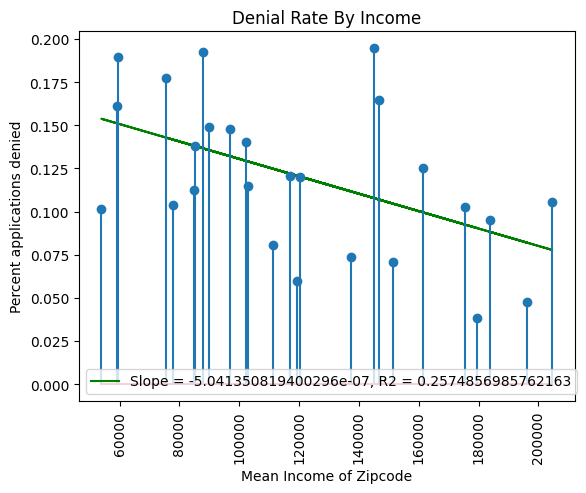

In [76]:
labels = [label for label in list(set(denied_df['zip']))]
y_vals = [
    ((denied_df[denied_df['zip'] == label]['zip'].count()) / (appeals_df[appeals_df['zip'] == label].shape[0])) for label in labels
]
x_vals = [zip_to_mean_income[int(label)] for label in labels]

a, b = np.polyfit(x_vals, y_vals, 1)
r2 = r2_score(y_vals, a*np.array(x_vals)+b)
plt.plot(x_vals, a*np.array(x_vals)+b, c='green', label=f'Slope = {a}, R2 = {r2}')
plt.legend()        

# Note: see that most appeals are approved, < 1000 are denied or denied with prejudice
plt.title("Denial Rate By Income")
plt.ylabel("Percent applications denied")
plt.xlabel("Mean Income of Zipcode")
plt.stem(x_vals, y_vals)
plt.xticks(rotation = 90)
plt.show()

In [54]:
bins = [list() for _ in range(7)]
bin_labels = ["< $80k", "$80-100k", "$100-120k", "$120-140k", "$140-160k", "$160-180k", "> 180k"]

for i, income in enumerate(x_vals):
    if income < 80_000:
        bins[0].append(y_vals[i])
    elif income < 100_000:
        bins[1].append(y_vals[i])
    elif income < 120_000:
        bins[2].append(y_vals[i])
    elif income < 140_000:
        bins[3].append(y_vals[i])
    elif income < 160_000:
        bins[4].append(y_vals[i])
    elif income < 180_000:
        bins[5].append(y_vals[i])
    else:
        bins[6].append(y_vals[i])

for i, bin in enumerate(bins):
    bins[i] = np.mean(bin)

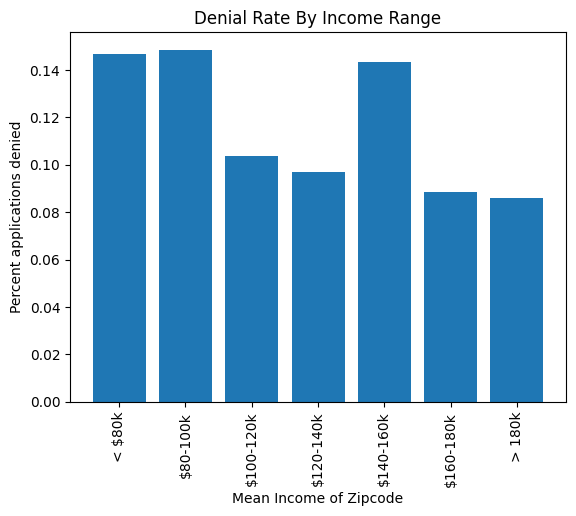

In [67]:
plt.title("Denial Rate By Income Range")
plt.ylabel("Percent applications denied")
plt.xlabel("Mean Income of Zipcode")
plt.bar(bin_labels, bins)
plt.xticks(rotation = 90)
plt.show()

In [58]:
np.mean(y_vals)

0.1209054448065609